In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/iai/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
original_dataset_dir = '/home/iai/Desktop/bsh/active_learning/data/mvtec30'
classes_list = os.listdir(original_dataset_dir)

train_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/data/splitted30/train', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/data/splitted30/test', transform=transform)

print(len(train_dataset))
print(len(test_dataset))

print(len(classes_list))

4271
1083
30


In [3]:
#Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Define loss function and optimizer
BATCH_SIZE = 4
EPOCHS = 35
criterion = nn.CrossEntropyLoss()

train_loss_list = []

# Train model on train dataset
def train(model, train_loader, optimizer, log_interval):
    model.train()
    train_loss = 0.0

    for _, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    # train_loss_list.append(train_loss)

    return train_loss


In [5]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

test_acc_list = []
test_loss_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []
test_fpr_list = []
test_tpr_list = []

# Evaluate model on test dataset
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
      n_samples = 0
      y_true = []
      y_pred = []
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          output = model(images)
          test_loss += criterion(output, labels).item()
          _, predicted = torch.max(output,1)
          n_samples += labels.size(0)
          test_accuracy += (predicted == labels).sum().item()
          y_true.extend(labels.tolist())
          y_pred.extend(predicted.tolist())
      test_accuracy /= n_samples
      test_loss /= len(test_loader)
      # test_acc_list.append(test_accuracy/n_samples * 100.)
      # test_loss_list.append(len(test_loader) * 100.)
      
      precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro', zero_division=1)
      # cm = confusion_matrix(y_true, y_pred)
      test_precision_list.append(precision)
      test_recall_list.append(recall)
      test_f1_list.append(f1)
      print(f"Test Precision: {precision.item():.4f}, Test Recall: {recall.item():.4f}, Test F1 Score: {f1.item():.4f}")
      
      # Convert multi-class labels to binary labels (OVR)
      lb = LabelBinarizer()
      lb.fit(y_true)
      y_true_bin = lb.transform(y_true)
      y_pred_bin = lb.transform(y_pred)

      # Compute AUC score and ROC curve
      fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
      auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
      roc_auc = auc(fpr, tpr)
      # test_auc_list.append(auc_score)
      test_fpr_list.append(fpr)
      test_tpr_list.append(tpr)
      # print(f"AUC Score: {auc_score:.4f}")

    return test_loss, test_accuracy, auc_score,f1

In [6]:
# Pretrained : 미리 학습된 resnet18모델을 불러온 후 이미지 데이터에 맞게 Fine Tuning

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
# Because num of class is 30
model.fc = nn.Linear(num_ftrs, 30)
model = model.cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [7]:
for EPOCH in range(EPOCHS):
    train(model, train_loader,optimizer, log_interval = 5)
    train_loss = train(model, train_loader,optimizer, log_interval = 5)
    train_loss_list.append(train_loss)
    print("[EPOCH:{}],\tTrain Loss: {:.4f},".format(EPOCH+1, train_loss))
 
test_loss, test_accuracy,auc_score, f1  = evaluate(model, test_loader)
test_acc_list.append(test_accuracy)
test_loss_list.append(test_loss)
test_auc_list.append(auc_score)
test_f1_list.append(f1)
print("-------------------------------------------------------------------")
print(f"Test F1 Score: {f1}")  
print("[EPOCH:{}],\tTest Loss: {:.4f}, \tTest Accuracy:{:.4f},\tAUC_score: {:.4f}\n".format(EPOCHS, test_loss, test_accuracy, auc_score))
print("-------------------------------------------------------------------")

[EPOCH:1],	Train Loss: 3.4008,
[EPOCH:2],	Train Loss: 2.6969,
[EPOCH:3],	Train Loss: 2.0784,
[EPOCH:4],	Train Loss: 1.6381,
[EPOCH:5],	Train Loss: 1.3619,
[EPOCH:6],	Train Loss: 1.1606,
[EPOCH:7],	Train Loss: 0.8943,
[EPOCH:8],	Train Loss: 0.7166,
[EPOCH:9],	Train Loss: 0.6117,
[EPOCH:10],	Train Loss: 0.5199,
[EPOCH:11],	Train Loss: 0.4883,
[EPOCH:12],	Train Loss: 0.4959,
[EPOCH:13],	Train Loss: 0.3766,
[EPOCH:14],	Train Loss: 0.3346,
[EPOCH:15],	Train Loss: 0.2906,
[EPOCH:16],	Train Loss: 0.2575,
[EPOCH:17],	Train Loss: 0.2590,
[EPOCH:18],	Train Loss: 0.2190,
[EPOCH:19],	Train Loss: 0.1754,
[EPOCH:20],	Train Loss: 0.1959,
[EPOCH:21],	Train Loss: 0.2200,
[EPOCH:22],	Train Loss: 0.1150,
[EPOCH:23],	Train Loss: 0.1017,
[EPOCH:24],	Train Loss: 0.0864,
[EPOCH:25],	Train Loss: 0.0793,
[EPOCH:26],	Train Loss: 0.0867,
[EPOCH:27],	Train Loss: 0.1578,
[EPOCH:28],	Train Loss: 0.0971,
[EPOCH:29],	Train Loss: 0.0557,
[EPOCH:30],	Train Loss: 0.0352,
[EPOCH:31],	Train Loss: 0.0320,
[EPOCH:32],	Train

In [8]:

print("[Test accuracy :{}]".format(test_acc_list))
print("[Test loss :{}]".format(min(test_loss_list)))

print(train_loss_list)
print(test_acc_list)
print(test_f1_list)
print(test_loss_list)

[Test accuracy :[0.15604801477377656]]
[Test loss :4.741022654316005]
[3.4008193994635967, 2.696857000020013, 2.0783661127980078, 1.6380500833490002, 1.3619295555486608, 1.1605929662821008, 0.8943255212880782, 0.7166282355840972, 0.6116792563793819, 0.5199251334641629, 0.4882827601743056, 0.495908933385873, 0.37656646241336617, 0.334646716700005, 0.2905542773625521, 0.2575131600528066, 0.25897624336683484, 0.21898675107730747, 0.17536274655791584, 0.19594234794225376, 0.22004678245258533, 0.11501983006540407, 0.1016643160881141, 0.08639482218848625, 0.07927945441976468, 0.08671108271697286, 0.1577680148288552, 0.0971114080739833, 0.055716716717414336, 0.03522190040693299, 0.031979807075669074, 0.04457970745097012, 0.018869612991476235, 0.039058657955559, 0.013649992269043352]
[0.15604801477377656]
[0.0849360023300077, 0.0849360023300077]
[4.741022654316005]


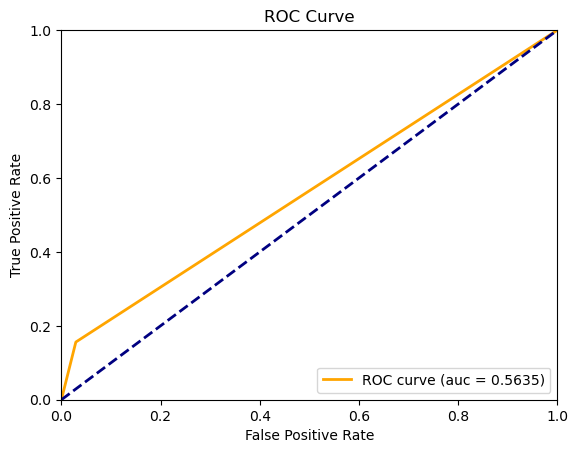

In [9]:
plt.plot(test_fpr_list[-1], test_tpr_list[-1], color='orange', lw=2, label='ROC curve (auc = %0.4f)' % auc(test_fpr_list[-1], test_tpr_list[-1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
# plt.plot(test_acc_list, color = 'yellow')
# plt.xlabel("EPOCHS")
# plt.ylabel("accuracy")
# plt.title('Train Accuracy of the ResNet18 with pretrained, epoch {}, class= 30'.format(EPOCHS))
# plt.show()

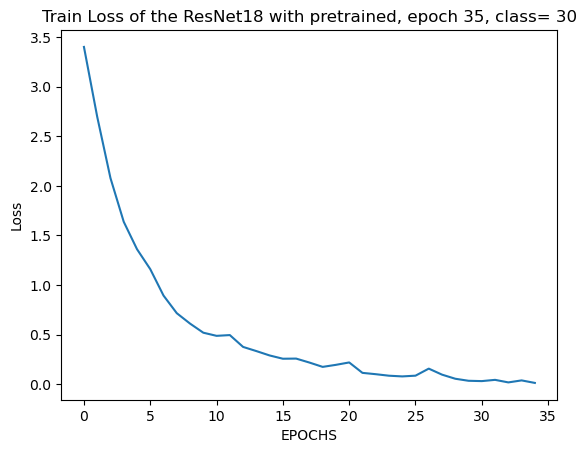

In [11]:
plt.plot(train_loss_list)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Train Loss of the ResNet18 with pretrained, epoch {}, class= 30'.format(EPOCHS))
plt.legend
plt.show()

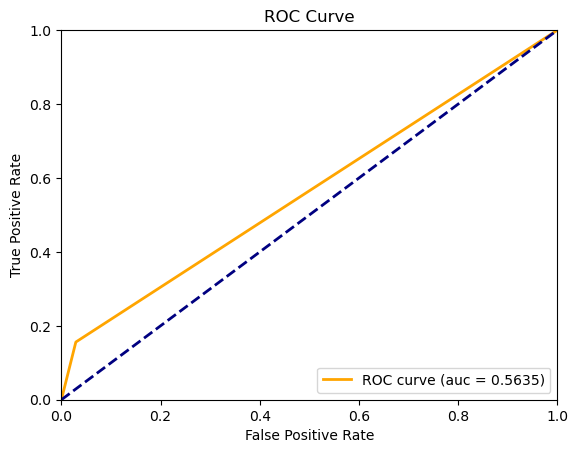

In [12]:
plt.plot(test_fpr_list[-1], test_tpr_list[-1], color='orange', lw=2, label='ROC curve (auc = %0.4f)' % auc(test_fpr_list[-1], test_tpr_list[-1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()